Exercise 3: Newton's method
===========================

We are going to implement Newton's method in multiple dimensions.

We are going to consider the following function:
$$
        E(x) = ||x||^4 - ||x||^2 - \frac 15 x_0,
$$
where $x = (x_0, x_1)^T$ and $||x||^2 = x_0^2 + x_1^2$.
Using $\partial_i ||x||^2 = 2 x_i$, one can work out the gradient
of this function:
$$
        J_i(x) = \frac{\partial E(x)}{\partial x_i} = (4 ||x||^2 - 2) x_i - \frac 15 \delta_{i0}
$$
First, write a function $E(x)$ which takes a numpy array $x$ as input and computes the energy
at $x$ and a function $J(x)$ which returns a numpy vector for the gradient at $x$.

Don't forget to import the numpy package.

In [245]:
import numpy as np

def E(x):
    x_norm_sq = x@x
    return np.power(x_norm_sq, 2) - x_norm_sq - 0.2 * x[0]
    
def J(x):
    return np.array([(4 * x@x - 2) * x[i] - 0.2 * (1 if i == 0 else 0) for i in range(len(x))])

In [246]:
E(np.array([-0.4,0.1]))

-0.061100000000000015

In [247]:
J(np.array([0.1,-0.2]))

array([-0.38,  0.36])

In [248]:
assert np.allclose(E(np.array([0.0,0.0])), 0, atol=1e-4)
assert np.allclose(E(np.array([0.5,0.2])), -0.3059, atol=1e-4)
assert np.shape(J(np.array([0.0,0.0]))) == (2,)
assert np.allclose(J(np.array([0.752619,0.0])), [0,0], atol=1e-4)


For your convenience, there is a false color plot of $E(x)$ below:

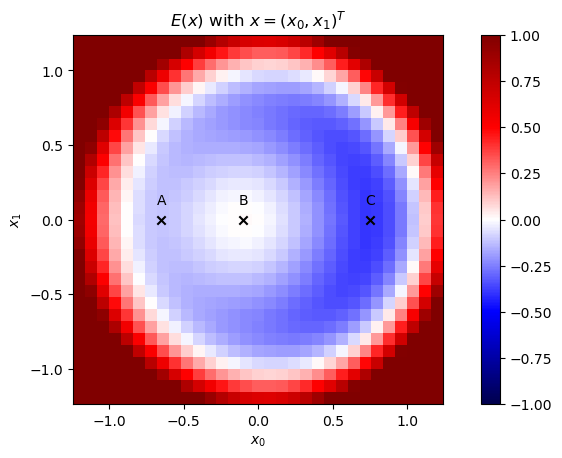

In [249]:
# You don't need to understand this code
def _plot(f):
    import matplotlib.pyplot as pl
    x = np.linspace(-1.2, 1.2, 31)
    fx = np.array([[f(np.array([a, b])) for a in x] for b in x])
    pl.pcolormesh(x, x, fx, cmap='seismic', vmax=1, vmin=-1, shading='auto')
    pl.colorbar()
    pl.xlabel(r'$x_0$')
    pl.ylabel(r'$x_1$')
    pl.title(r'$E(x)$ with $x = (x_0, x_1)^T$')
    pl.axis('scaled')
    x0 = [-0.6505, -0.10213, 0.75262]
    pl.scatter(x0, [0, 0, 0], marker='x', c='k')
    for x0i, t in zip(x0, 'ABC'): pl.text(x0i, 0.1, t, ha='center')

_plot(E)

In the above plot, I have marked points (A,B,C) where the gradient is zero:

$$
\begin{aligned}
 x_A &\approx (-0.6505, 0)^T \\
 x_B &\approx (-0.10213, 0)^T \\
 x_C &\approx (0.75262, 0)^T \\
\end{aligned}
$$

Identify the character of these points below:

The potential is basically a 2D mexican hat potential with a slight amplitude increase along the positive $x_0$ axis. Thus the three marked points have the following character

x_A: Saddle point

x_B: Local Maximum

x_C: Global Minimum

Adapt your gradient descent solver (without Nesterov acceleration) from the
previous exercise so that it can handle any dimension.

`x0` is then a numpy array corresponding to the first points, `grad` is a
function taking and returning an array.  Be mindful: in numpy, comparisons are
component-by-component (this may lead to an error).

In [250]:
def gradient_descent(grad, x0, eta, max_iter, returnPath = False):
    
    # set starting point
    x = x0.copy()
    path = [x0]
    # do the loop max_iter times
    for _ in range(max_iter):
        # calc step
        v = - eta * grad(x)
        # if tolerance achieved stop looping
        if np.linalg.norm(v, 2) < 1e-5: break
        # update x
        x += v
        path.append(x.copy())
        
    # returns list of all points 
    if returnPath:
        return path
    #  returns only the final point
    return x

In [251]:
gradient_descent(J, np.array([0.1, 0.1]), 0.1, 20)

array([0.70132512, 0.26459995])

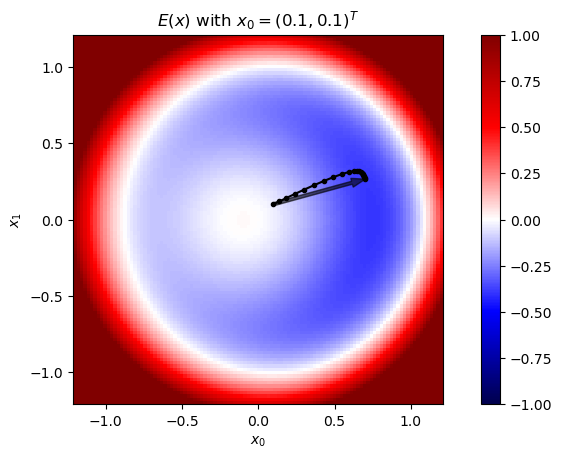

In [252]:
def _plotPath(f, path, path2=None, labels=[None, None]):
    import matplotlib.pyplot as pl
    x = np.linspace(-1.2, 1.2, 111)
    fx = np.array([[f(np.array([a, b])) for a in x] for b in x])
    pl.pcolormesh(x, x, fx, cmap='seismic', vmax=1, vmin=-1, shading='auto', zorder=-1)
    pl.colorbar()
    pl.xlabel(r'$x_0$')
    pl.ylabel(r'$x_1$')
    pl.title(f'$E(x)$ with $x_0 = ({path[0][0]}, {path[0][1]})^T$')
    pl.axis('scaled')
    
    # plot path(s)
    pl.plot([p[0] for p in path], [p[1] for p in path], c='k', marker="o", markersize=3, label=labels[0], zorder=100)
    # plot arrow from start to end
    pl.arrow(path[0][0], path[0][1], (path[-1][0] - path[0][0]), (path[-1][1] - path[0][1]), width=0.02, color="k", alpha=0.6, length_includes_head=True, zorder=99)
    
    if path2 != None:
        pl.plot([p[0] for p in path2], [p[1] for p in path2], c='C1', marker="o", markersize=3, label=labels[1], zorder=50)
        pl.arrow(path2[0][0], path2[0][1], (path2[-1][0] - path2[0][0]), (path2[-1][1] - path2[0][1]), color="orange", alpha=0.6, width=0.03, length_includes_head=True, zorder=49)
        pl.legend()
    


_plotPath(E, path=gradient_descent(J, np.array([0.1, 0.1]), 0.1, 20, returnPath=True))

Note that the minimum found by the above code is off by quite a bit ... why?

How can you change the parameters so that it works better?  Would acceleration help?

Because our gradient descent function does not take the local curvature of the surface into account the steps taken are not necessarily in the ideal direction but rather just in the direction of steepest slope along each axis. Thus if we choose a starting point where both coordinates differ from the coordinates of the minimum point we will first veer off the ideal path and then with more iterations slowly approach the minimum. 

### Better Parameters
+ The simplest improvement would be to add more steps (increase _maxiter_), then we can afford to waste the first few steps going the wrong way
+ Changing the starting point to line up with the minimum in the y coordinate. Then because of the symmetry in the y-axis we basically are left with a 1D gradient descent problem (The _x0_ coordinate must be _>0_ otherwise we get stuck at the saddle point.
+ You could also vary **eta** a little bit to get slightly faster convergence, but this wont help that much since we still have the issue of not knowing the curvature.


### Does Acceleration help?
Using acceleration would not help much because we have the same issue of not using the curvature of the surface. Acceleration may give small gains in convergence speed but we would see the same behaviour of the algorithm first walking in the wrong/non-ideal direction. We would get improvements but not by many orders of magnitude

[7.52618474e-01 3.73360158e-04]


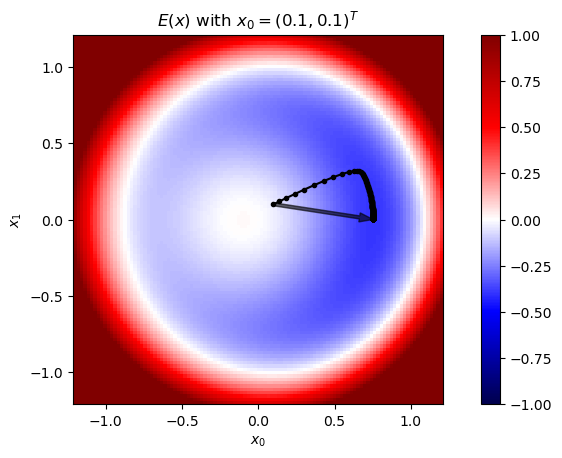

In [253]:
# USING MORE STEPS
start = [0.1, 0.1]
path = gradient_descent(J, np.array(start, dtype=float), 0.1, 2000, returnPath=True)
_plotPath(E, path)
print(path[-1])

[0.75249552 0.        ]


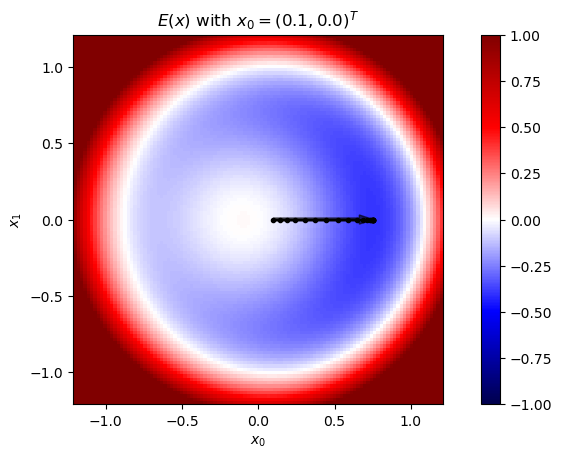

In [254]:
# Better starting point
start = [0.1, 0]
path = gradient_descent(J, np.array(start, dtype=float), 0.1, 20, returnPath=True)
_plotPath(E, path)
print(path[-1])

[-0.65046126  0.        ]


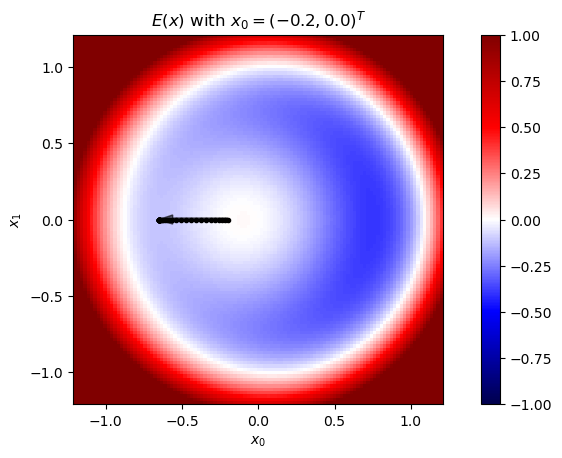

In [304]:
# Stuck at saddle point because when x1=0 GD sees saddle point as a local minimum
start = [-0.2, 0.]
path = gradient_descent(J, np.array(start, dtype=float), 0.1, 2000, returnPath=True)
_plotPath(E, path)
print(path[-1])

[7.52618474e-01 3.73153624e-04]


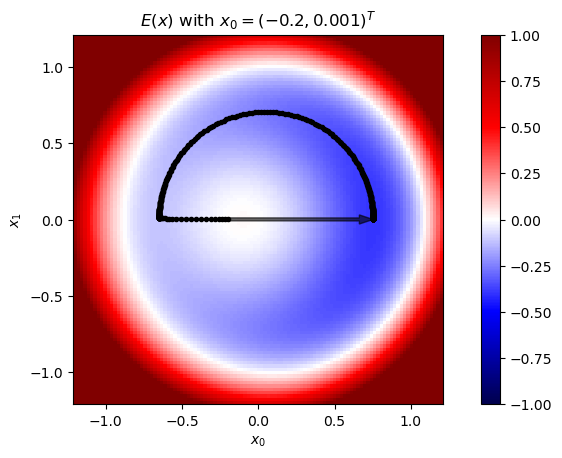

In [306]:
# Same as above with tiny change in y, now saddle no longer looks like local minimum
start = [-0.2, 0.001]
path = gradient_descent(J, np.array(start, dtype=float), 0.1, 2000, returnPath=True)
_plotPath(E, path)
print(path[-1])

Hessian
------------

The Hessian of $E$ is given by the second derivatives, which are:
$$
    H_{ij}(x) = \frac{\partial^2E(x)}{\partial x_i\partial x_j}  = (4 ||x||^2 - 2) \delta_{ij} + 8 x_i x_j
$$
Implement this in the function $H$ below, which returns a $2\times 2$ numpy matrix.

In [256]:
def H(x):
    # precompute norm and delta here to avoid redundant computations
    x_norm_sq = x@x
    I = np.eye(len(x))
    return  np.array([[ (4 * x_norm_sq - 2) * I[i][j] + 8*x[i]*x[j] for j in range(len(x))] for i in range(len(x))])

In [257]:
H(np.array([0.1,0.3]))

array([[-1.52,  0.24],
       [ 0.24, -0.88]])

In [258]:
assert H(np.array([0.0,0.0])).shape == (2, 2)
assert np.allclose(H(np.array([0.0,0.0])), [[-2, 0], [0, -2]], atol=1e-5)
assert np.allclose(H(np.array([1.0,2.0])), [[26, 16], [16, 50]], atol=1e-5)


Let's remind ourselves of the points (A,B,C) where the gradient is zero:

$$\begin{aligned}
 x_A &\approx (-0.6505, 0)^T \\
 x_B &\approx (-0.10213, 0)^T \\
 x_C &\approx (0.75262, 0)^T \\
\end{aligned}$$

Compute the Hessian for these points and prove the character you identified above
using the Hessian.

In [259]:
# This function assumes the point has a derivative of 0
def findPointCharacter(point):
    # Calc hessian and positive/negative semidefinite classifier
    hess = H(point)
    Htest = hess[0,0] * hess[1,1] - hess[0,1] ** 2
    
    # print point and hessian
    print("Point:\n", point, "\n")
    print("Hessian:\n", hess, "\n")
    
    # identify and print point character
    if Htest < 0:
        print("------------\nSaddle Point\n------------\n")
    else:
        if hess[0,0] < 0:
            print("-------------\nMaximum Point\n-------------\n")
        else:
            print("-------------\nMinimum Point\n-------------\n")

In [260]:
point = np.array([-0.6505,0])
findPointCharacter(point)

Point:
 [-0.6505  0.    ] 

Hessian:
 [[ 3.077803 -0.      ]
 [-0.       -0.307399]] 

------------
Saddle Point
------------



In [261]:
point = np.array([-0.10213,0])
findPointCharacter(point)

Point:
 [-0.10213  0.     ] 

Hessian:
 [[-1.87483356 -0.        ]
 [-0.         -1.95827785]] 

-------------
Maximum Point
-------------



In [262]:
point = np.array([0.75262,0])
findPointCharacter(point)

Point:
 [0.75262 0.     ] 

Hessian:
 [[4.79724237 0.        ]
 [0.         0.26574746]] 

-------------
Minimum Point
-------------



Summarize your findings below:

As can be seen form the cells above the hessian confirms the initial predictions I made about the character of the extremal points

$x_A$: Saddle point

$x_B$: (Local) Maximum

$x_C$: (Global) Minimum

Newton's method
---------------
Let's combine everything and implement Newton's method.
You can start, e.g., from the code of your `gradient_descent` method.

Newton's method shall take a function for the gradient `grad` a function for
the Hessian `hess`, a start point `x0`, a small non-negative regularization parameter `lambda_`
(note the trailing underscore), a learning rate `eta` between 0 and 1, and
the maximum  number of iterations.

Hint `x.size`  gives the total number of elements in an array.

In [263]:
def newton(grad, hess, x0, lambda_=0, eta=1, max_iter=20, returnPath=False):
    # set starting point
    x = x0.copy()
    path = [x0]
    # do the loop max_iter times
    for _ in range(max_iter):
        # calc step
        v = - eta * np.linalg.inv(hess(x) + lambda_ * np.eye(2)) @ grad(x)
        # if tolerance achieved stop looping
        if np.linalg.norm(v, 2) < 1e-5: break
        # update x
        x += v
        path.append(x.copy())
    
    # return all points traversed
    if returnPath:
        return path
    # return only the final point
    return x

In [264]:
assert newton(J, H, np.array([0.0, 0.0])).shape == (2,)
assert np.allclose(newton(J, H, np.array([0.0, 0.0]), max_iter=0), [0.0, 0.0], atol=1e-4)
assert np.allclose(newton(J, H, np.array([0.8, -0.1])), [0.752619, 0.0], atol=1e-4)
assert np.allclose(newton(J, H, np.array([0.4, 0.1])), [0.752619, 0.0], atol=1e-4)


Compare the results for Newton's method and Gradient Descent for the starting point $x = (-0.5, 0.05)$. (For gradient descent you probably need a large number of iterations.)

Also investigate the result for the starting point $x = (0, 0)$.

In [281]:
def NewtonGDCompare(start, lambda_=0):
    path = newton(J, H,np.array(start, dtype=float), lambda_=lambda_, max_iter=200, returnPath=True)
    path2 = gradient_descent(J, np.array(start, dtype=float), 0.1, 2000, returnPath=True)
    labels=[f"Newton, steps: {len(path)}", f"GD, steps: {len(path2)}"]
    _plotPath(E, path, path2, labels)

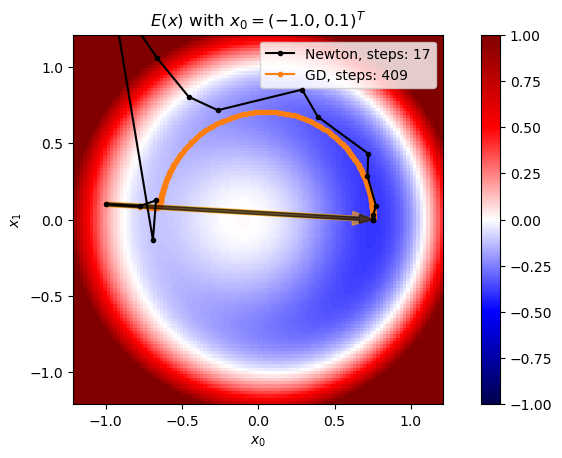

In [287]:
# Lambda=0 makes newton go on a slightly (yet efficient) crazy path
NewtonGDCompare([-1, 0.1], lambda_=0)

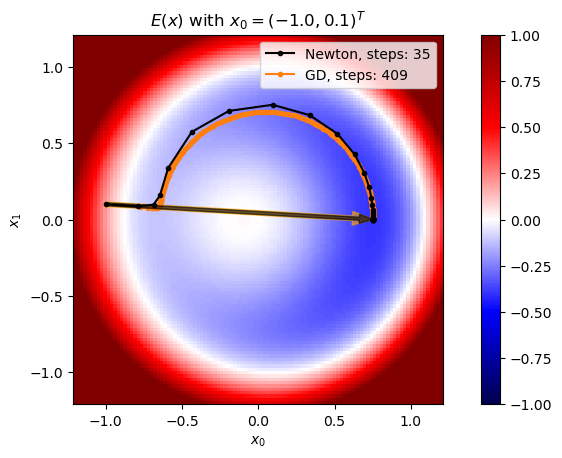

In [288]:
# higher Lambda makes newton follow GD path, but in a more efficient way than GD (pretty neat)
NewtonGDCompare([-1, 0.1], lambda_=0.5)

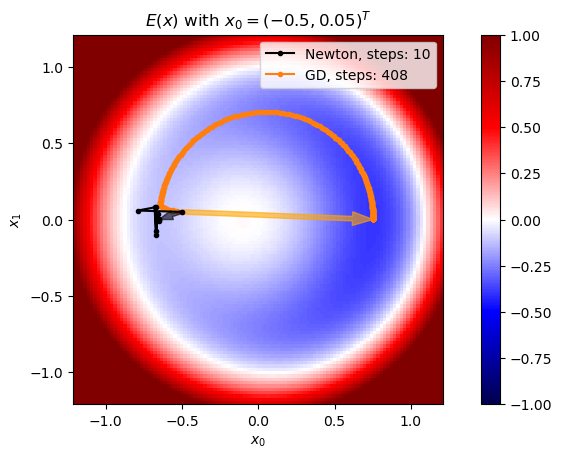

In [297]:
NewtonGDCompare([-0.5, 0.05], lambda_=0)

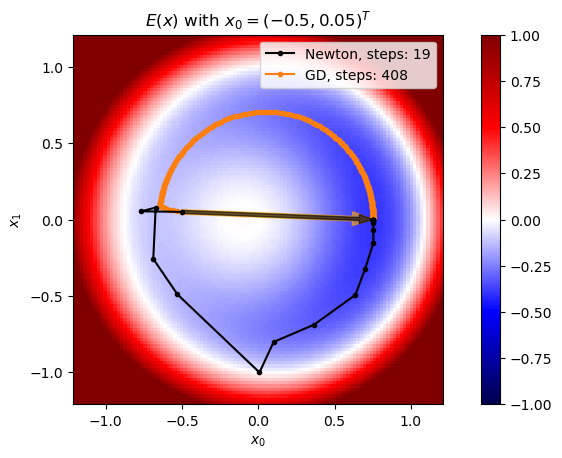

In [300]:
NewtonGDCompare([-0.5, 0.05], lambda_=0.1)

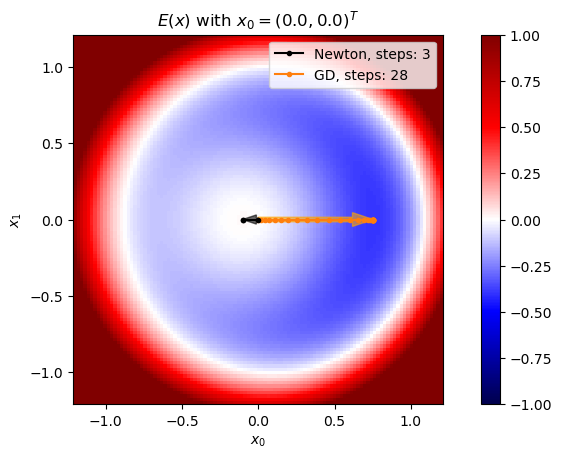

In [291]:
 NewtonGDCompare([0, 0])

What happens in each approach and why?

## x0 = [-0.5, 0.05]
We see that for this starting point if _lambda=0_ the **Newton Method** Fails to converge to the minimum and instead gets stuck at the Saddle Point. GD converges to the minimum as expected.

This is because the newton method seeks points with gradient 0 and on non-convex surfaces (such as the one given) it can be attracted to saddle points if it starts off in the correct location. The newton method on the other hand always seeks local minima and unless it lands exactly on a saddle point it will not be attracted to one.

However we see that if we set _lambda > 0_ then we can bias the Newton Method towards behaving like gradient descent just enough for it to not get stuck at the saddle point and then it does indeed find the minimum

## x0 =[0, 0]
In this case the **Newton Method** is attracted to and then converges at the local maximum point, where as GD still converges to the minimum. The reasoning is essentially the same. Newton method approximates the surface with a quadratic equation and then jumps to the extremum point of that quadratic without regard for it being a maximum or a minimum. Thus if a local maximum exists and we start sufficiently close to it the Newton Method gets attracted towards it

Overall we can see that the Newton method brings tremendous performance gains because it uses a lot less iterations to reach the minimum. But because it is attracted to saddle points and maxima as well as minima one must choose the starting location very carefully or one may run into issues.